In [1]:
#!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

print("numpy version: {}".format(np.__version__))
print("Networkx version: {}".format(nx.__version__))

from scipy.stats import norm
import numexpr
numexpr.print_versions()
%matplotlib inline

Networkx version: 2.4
numpy version: 1.17.2
Networkx version: 2.4
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Numexpr version:   2.7.0
NumPy version:     1.17.2
Python version:    3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
Platform:          linux-x86_64-#1 SMP Mon Sep 16 14:19:51 EDT 2019
CPU vendor:        
CPU model:         
CPU clock speed:    MHz
VML available?     True
VML/MKL version:   Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
Number of threads used by default: 8 (out of 64 detected cores)
Maximum number of threads: 64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [2]:
import tensorflow as tf
print(tf.__version__)

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")


import os
print(os.environ['HOME'])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

2.0.0
Using a GPU
/u/yan30


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]

'0'

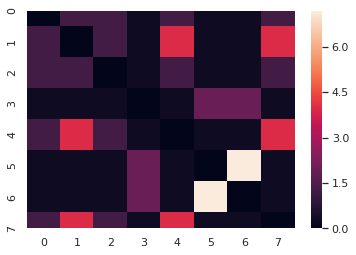

In [4]:
G = nx.read_edgelist("data/resnik.txt", delimiter='\t' , nodetype=str,  data=(('weight',float),))
H = G.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH1':1, 'ALKBH2':2, 'ALKBH3':4}
G0 = nx.relabel_nodes(H, mapping)
A = nx.adjacency_matrix(G0)
ax = sns.heatmap(A.todense())

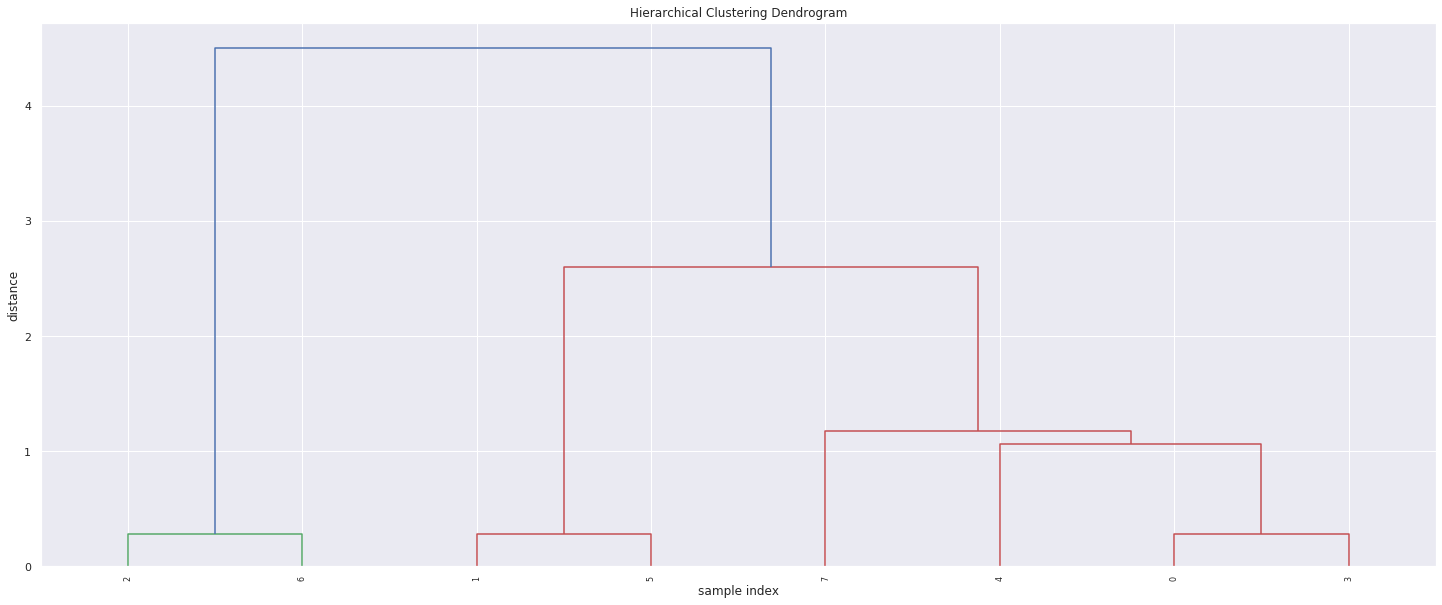

array([[ 0.        ,  3.        ,  0.27963638,  2.        ],
       [ 1.        ,  5.        ,  0.27963638,  2.        ],
       [ 2.        ,  6.        ,  0.27963638,  2.        ],
       [ 4.        ,  8.        ,  1.05721886,  3.        ],
       [ 7.        , 11.        ,  1.17370802,  4.        ],
       [ 9.        , 12.        ,  2.60322641,  6.        ],
       [10.        , 13.        ,  4.49761348,  8.        ]])

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

listA = squareform(A.todense())
Z = linkage(listA, 'ward')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
Z

In [8]:
import pymc3 as pm
import theano.tensor as tt

def make_pymc3_sbm(Gs, k, labels, directed=False, selfloops=False):
    # input can be a single graph or a list of graphs
    if isinstance(Gs, nx.Graph):
        Gs = [Gs]
    n = len(Gs[0])
    # whether to include the diagonal or not
    if selfloops:
        triu_indices = np.triu_indices(n, k=1)
    else:
        triu_indices = np.triu_indices(n)
    # convert to adjacency matrix
    # if graph is undirected, we just need the upper triangular part
    if directed:
        A_obs = np.array([nx.to_numpy_array(G) for G in Gs])
    else:
        A_obs = np.array([nx.to_numpy_array(G)[triu_indices] for G in Gs])

    model = pm.Model()
    with model:
        #pi = pm.Dirichlet('pi', a=np.ones(k), shape=(k,))
        z = labels #pm.Categorical('z', p=pi, shape=(n,))
        eta = pm.Normal('eta', mu=10, sd = 1, shape=(k, k))#.astype('float32')
        # parameters to sample the adjacency matrix
        # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
        p = eta[(z.reshape((n, 1)), z.reshape((1, n)))]
        if not selfloops:
            tt.set_subtensor(p[np.diag_indices(n)], 0.)
        if not directed:
            p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices]
        W = pm.Normal('W', mu=p, sd=1, shape=A_obs[0].shape, observed=A_obs)#.astype('float32')
    return model

ModuleNotFoundError: No module named 'pymc3'

In [5]:
k = 3
labels = np.full(shape=len(G),fill_value=0)
labels[::3] = 1
model = make_pymc3_sbm(G, k, labels)
with model as m1:
    #start = pm.find_MAP()
    #trace = pm.sample(50000, start=start, progressbar=True)
    trace1 = pm.sample(500, tune = 500,)

/N/soft/rhel7/deeplearning/Python-3.6.8/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/N/soft/rhel7/deeplearning/Python-3.6.8/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/N/soft/rhel7/deeplearning/Python-3.6.8/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: F

ValueError: Not enough samples to build a trace.

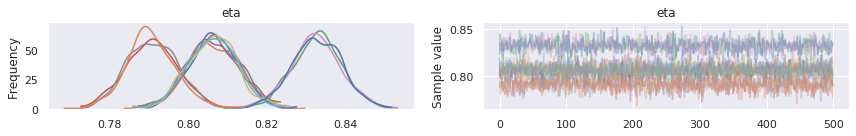

In [17]:
pm.traceplot(trace1);

In [18]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
eta__0_0,0.806526,0.006289,0.000156,0.795399,0.819532,1509.904629,0.999666
eta__0_1,0.832539,0.006468,0.000164,0.820724,0.846360,1588.340047,1.000041
eta__1_0,0.806286,0.006623,0.000130,0.792825,0.819012,1971.517655,0.999522
eta__1_1,0.790701,0.006497,0.000165,0.777662,0.803034,1713.584897,0.999712


In [5]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_prob(G, k, labels, directed=False, selfloops=False):
  # the SBM log-likelihood generative steps
    n = len(G)
    z = labels
    eta = ed.Normal(loc=10, scale=1, name="eta", sample_shape=[k,k]) #beta prior for simple edges
    # parameters to sample the adjacency matrix
    # p[i, j] = eta[z[i], z[j]] is the parameter corresponding to A[i, j]
    # very inefficient parameterization
    tile_a = tf.tile(tf.expand_dims(z, 1), [1, tf.shape(z)[0]])  
    tile_a = tf.expand_dims(tile_a, 2) 
    tile_b = tf.tile(tf.expand_dims(z, 0), [tf.shape(z)[0], 1]) 
    tile_b = tf.expand_dims(tile_b, 2)
    p = tf.gather_nd(eta, tf.concat([tile_a, tile_b], axis=2))
    #if not selfloops:
    #    TT.set_subtensor(p[np.diag_indices(n)], 0.)
    #if not directed:
    #    p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
    #if weighted:
    #    A = ed.Poisson(name = 'A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
    #else:
    A = ed.Normal(name = 'A', loc=p, scale=1)
    return A

In [6]:
log_joint = ed.make_log_joint_fn(SBM_prob)
# Function to compute the log posterior probability
n = len(G)
A_obs = tf.convert_to_tensor(nx.to_numpy_array(G), dtype=tf.float32)

#def setParameters(k, label):
k = 3
label = np.random.randint(low = 0, high = 3, size = n) 

def target_log_prob_fn(eta):
  return log_joint(
      G = G,
      k = k,
      labels = label,
      eta = eta,
      A=A_obs)

# set initial state (drawn from prior)
peta = tf.random.uniform([k,k], minval=0, maxval=1, dtype=tf.float32)
print(target_log_prob_fn(peta)) #test the target_log_prob_fn with initial state
np.exp(target_log_prob_fn(peta).numpy())

tf.Tensor(-307238.06, shape=(), dtype=float32)


/u/yan30/.conda/envs/tf-prob/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  """Entry point for launching an IPython kernel.


0.0

In [7]:
Nsamples = 5000  # final number of samples
Nburn = 5000     # number of tuning samples

# set up Hamiltonian MC
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.01,
    num_leapfrog_steps=5)

def sample():
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=Nsamples,
        num_burnin_steps=Nburn,
        current_state=[peta],
        trace_fn=(lambda current_state, kernel_results: kernel_results),
        parallel_iterations=100,
        kernel=hmc_kernel)
    return kernel_results.proposed_results.target_log_prob.numpy().mean()
#kernel_results.is_accepted.numpy().mean()

In [ ]:
import cProfile
cProfile.run('sample()')

In [239]:
def updateDAG(G, NodeMerge):
    size = len(NodeMerge);
    u,v = NodeMerge[0]
    for i in range (0,size):
        print(NodeMerge[i])
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        B = np.vstack([A, (A[nodes[0],:]+A[nodes[1],:])/2])
        A = np.column_stack([B, (B[:,nodes[0]]+B[:,nodes[1]])/2])
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    H = nx.from_numpy_matrix(A)
    H.remove_node(u)
    H.remove_node(v)
    #print(H.node())
    return H

In [111]:
def getCandidates(G, labels):
    A = nx.adjacency_matrix(G).todense()
    np.fill_diagonal(A, 9999)
    am = A.argmin() #find min pair
    c0 = am % A.shape[1]
    r0 = am // A.shape[1]
    A[c0,r0] = 9999
    A[r0,c0] = 9999
    c1 = A[r0,:].argmin() #find 2nd min pair
    r1 = A[:,c0].argmin() #find 2nd min pair
    
    Llist = []    
    labelsNew = labels.copy()
    labelsNew[r0] = labelsNew[c0]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    labelsNew = labels.copy()
    labelsNew[r0] = labelsNew[c1]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    labelsNew = labels.copy()
    labelsNew[c0] = labelsNew[r1]
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)
    return Llist

In [175]:
def buildLayer(G, k, Llist):
    Mlist = []
    Tlist = []

    for iteration in range (0,3):
        labels = Llist[iteration]
        model = make_pymc3_sbm(G, k, labels)
        with model as modelX:
            trace = pm.sample(1500, tune = 500)
        Mlist.append(modelX)
        Tlist.append(trace)

    Mlist[0].name = '0'
    Mlist[1].name = '1'
    Mlist[2].name = '2'
    comp = pm.compare({Mlist[0]: Tlist[0], Mlist[1]: Tlist[1], Mlist[2]: Tlist[2]}, method='BB-pseudo-BMA')
    #print(comp.weight)
    return comp.weight

In [ ]:
from collections import Counter

label = np.array([0, 1, 2, 3, 4, 5, 6, 7])
Gnew = G0 
while True:
    k = len(Gnew)
    label = np.arange(k)
    Llist = getCandidates(Gnew,label)
    ModelPosterior = buildLayer(Gnew, k-1, Llist)
    thresh = ModelPosterior['0'] + 0.3 #use the closest pair as the posterior threshold, increase to speed up convergence
    newInternal = ModelPosterior[ModelPosterior  > thresh].index.astype(int)
    NodeMerge = [] #nodes to be merged, closest pair added as the defult
    dup = [item for item, count in Counter(Llist[0]).items() if count > 1]
    nodes = np.where(Llist[0] == dup[0])
    NodeMerge.append(nodes[0])
    print(Llist[0])
    for i in range (0,len(newInternal)):
        newLabel = Llist[newInternal[i]]
        print(newLabel)
        dup = [item for item, count in Counter(newLabel).items() if count > 1]
        nodes = np.where(newLabel == dup[0])
        NodeMerge.append(nodes[0])
    Gnew = updateDAG(Gnew, NodeMerge) #update the graph with node mergers/splits
    if k<=3:
        break    

/home/jovyan/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jovyan/.local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1110.32draws/s]
Auto-assign

0    0.43
2    0.45
1    0.13
Name: weight, dtype: object
[0 0 1 2 3 4 5 6]
[0 1]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1235.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1266.85draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1204.96draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pr

2    0.47
0     0.4
1    0.13
Name: weight, dtype: object
[0 0 1 2 3 4 5]
[0 1]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1314.28draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1339.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1346.73draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pr

0    0.55
1    0.41
2    0.04
Name: weight, dtype: object
[0 0 1 2 3 4]
[0 1]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:06<00:00, 968.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:05<00:00, 1116.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:14<00:00, 420.64draws/s]
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/jovyan/.local/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log pred

2    0.68
0    0.28
1    0.05
Name: weight, dtype: object
[1 0 1 2 3]
[0 1 2 2 3]
[0 2]
[2 3]


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1212.93draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta]
Sampling 3 chains:  64%|██████▍   | 3832/6000 [00:03<00:01, 1263.35draws/s]

In [153]:
Llist[newInternal[0]]

array([0, 2, 1, 2, 3, 4, 5, 6])

In [112]:
label = np.array([0, 1, 2, 3, 4, 5, 6, 7])
Llist = getCandidates(G0,label)
Llist

[array([0, 0, 1, 2, 3, 4, 5, 6]),
 array([1, 0, 1, 2, 3, 4, 5, 6]),
 array([0, 2, 1, 2, 3, 4, 5, 6])]